In [7]:
import sys
sys.path.append('../src/')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import alphashape
import shapely
from shapely.geometry import Point, Polygon, MultiPolygon

from sklearn.cluster import Birch
import itertools
from matplotlib import patches
from matplotlib.path import Path

from scipy.spatial import Voronoi

In [8]:
sns.set_style("darkgrid")

In [9]:
def anchors_to_contour(points, delta=0.4):
    x_plus_arr = points.copy()
    x_plus_arr[:, 0] = points[:, 0] + delta
    x_minus_arr = points.copy()
    x_minus_arr[:, 0] = points[:, 0] - delta
    y_plus_arr = points.copy()
    y_plus_arr[:, 1] = points[:, 1] + delta
    y_minus_arr = points.copy()
    y_minus_arr[:, 1] = points[:, 1] - delta

    points_discs = np.concatenate([x_plus_arr, x_minus_arr, y_plus_arr, y_minus_arr])
    return points_discs

def smooth_poly_Douglas_Peucker(poly, douglas_peucker_tolerance):
    _poly = Polygon(poly)
    _poly = _poly.simplify(douglas_peucker_tolerance, preserve_topology=True)
    x, y = _poly.exterior.coords.xy
    return list(zip(x, y))

def smooth_poly_Chaikins_corner_cutting_iter(poly, iter=1):
    new_poly = poly[:]
    for i in range(iter):
        new_poly = smooth_poly_Chaikins_corner_cutting(new_poly, True)
    return new_poly

def smooth_poly_Chaikins_corner_cutting(poly, append_first_point):
    """
    poly is list of lists
    example: poly1 = [
    [3,3],
    [4,4],
    [5,4],
    [5,7],
    [6,8],
    [7,5],
    [6,3],
    [5,2],
    [4,2],
    [3,3]
    ]
    Based on https://stackoverflow.com/questions/27642237/smoothing-a-2-d-figure
    Q(i) = (3/4)P(i) + (1/4)P(i+1)
    R(i) = (1/4)P(i) + (3/4)P(i+1)
    """
    new_poly = []
    for i in range(len(poly) - 1):
        q_i = [0.75 * poly[i][0] + 0.25 * poly[i + 1][0], 0.75 * poly[i][1] + 0.25 * poly[i + 1][1]]
        r_i = [0.25 * poly[i][0] + 0.75 * poly[i + 1][0], 0.25 * poly[i][1] + 0.75 * poly[i + 1][1]]
        new_poly.extend([q_i, r_i])
    # append first point for smoothness
    if append_first_point:
        new_poly.append(new_poly[0])
    return new_poly

def get_concave_hull(points, alpha, spline=False, vis=False, douglas_peucker_tolerance=0.6, smooth_iter=13):
    alpha_shape = alphashape.alphashape(points.tolist(), alpha)
    smooth_shapes = []
    if isinstance(alpha_shape, shapely.geometry.polygon.Polygon):
        alpha_shape = [alpha_shape]
    else:  # Multipolygon
        alpha_shape = list(alpha_shape)
    for shape in list(alpha_shape):
        x, y = shape.exterior.coords.xy
        if not spline:
            if vis:
                smooth_shape = np.array(smooth_poly_Chaikins_corner_cutting_iter(
                                    smooth_poly_Douglas_Peucker(list(zip(x, y)), douglas_peucker_tolerance),
                    iter=smooth_iter))
            else:
                smooth_shape = np.array(list(zip(x, y)))
        else:
            tck, u = splprep([np.array(x), np.array(y)], s=3)
            new_points = splev(u, tck)
            x, y = new_points[0], new_points[1]
            smooth_shape = np.array(list(zip(x,y)))
        smooth_shapes.append(smooth_shape)
    return smooth_shapes

In [10]:
def points_anchors_patches_plot(df, df_centroids, concave_hulls, 
                                show_inner_blobs=False, show_points=True, show_anchors=False, show_polygons=True):
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Plot points
    if show_points:
        sns.scatterplot(data=df, x='x', y='y',
                        ax=ax, color='green', s=50, linewidth=1, edgecolor='black')
    # Plot anchors
    if show_anchors:
        sns.scatterplot(data=df_centroids, x='x', y='y',
                        ax=ax, color='red', s=250, linewidth=1, edgecolor='black')

    # Add patches
    if show_polygons:
        palette = itertools.cycle(sns.color_palette())
        c = next(palette)
        for concave_hull in concave_hulls:
            # Skip polygons with very small area that will appear as dots
            if Polygon(concave_hull).area < 0.001:
                self.print_verbose(f'Skipping polygon of label {label} with area {Polygon(concave_hull).area}')
                continue
            coords = concave_hull
            line_cmde = [Path.MOVETO] + [Path.LINETO] * (len(coords) - 2) + [Path.CLOSEPOLY]
            path = Path(coords, line_cmde)
            patch = patches.PathPatch(path, facecolor=c, alpha=0.2, linewidth=None, edgecolor=None)
            ax.add_patch(patch)
            patch = patches.PathPatch(path, facecolor=None, linewidth=10, edgecolor=c, fill=False)
            ax.add_patch(patch)

        if show_inner_blobs:
            points = df_centroids[['x', 'y']].values
            vor = Voronoi(points)

            regions, vertices = voronoi_finite_polygons_2d(vor)

            mask = Polygon(concave_hulls[0])
            for region in regions:
                polygon = vertices[region]
                shape = list(polygon.shape)
                shape[0] += 1
                p = Polygon(np.append(polygon, polygon[0]).reshape(*shape)).intersection(mask)
                # intersection can create MultiPolygon
                if isinstance(p, shapely.geometry.polygon.Polygon):
                    polygons = [p]
                else:  # Multipolygon
                    polygons = list(p)

                for p in list(polygons):
                    # skip anchors outside the polygon due to simplification
                    if p.exterior is None:
                        continue
                    x, y = p.exterior.coords.xy
                    inner_blob = list(zip(x,y))
                    #plot patch
                    line_cmde = [Path.MOVETO] + [Path.LINETO] * (len(inner_blob) - 2) + [Path.CLOSEPOLY]
                    path = Path(inner_blob, line_cmde)
                    patch = patches.PathPatch(path, facecolor=None, linewidth=5, edgecolor=c, fill=False)
                    ax.add_patch(patch)
        
    # remove ticks
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())
    # remove labels
    ax.set_xlabel("")
    ax.set_ylabel("")

    plt.show()

In [11]:
def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.

    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.

    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.

    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1]  # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:, 1] - c[1], vs[:, 0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

In [12]:
from itertools import cycle, islice
def vis_2d_(points,y):
    colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y) + 1))))
    target = np.hstack([y])
    sns.set(style='white', context='poster')
    fig, ax = plt.subplots(1, figsize=(4, 2))
    plt.scatter(*points.T, s=1, color=colors[y], cmap='Spectral', alpha=1.0)
    plt.setp(ax, xticks=[], yticks=[])
#     cbar = plt.colorbar(boundaries=np.arange(4)-0.5)
#     cbar.set_ticks(np.arange(10))
def vis_2d_new(ds,df,size=100,show_label=False):
    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(111)
    feature_col = ['X','Y']
#     df = ds.df
    #     x = df[feature_col]
    label = ds.label_col
    y = df[label]
    cluster_label = y.unique()
    for i in cluster_label:
        cluster_df = df[df[label]==i]
        cluster = df[df[label]==i][feature_col].values
        cluster.shape
        ax.scatter(*cluster.T, s=size, alpha=0.6, edgecolors='w')
        if show_label:
            for j, anchor_i in enumerate(cluster_df.index):
                ax.text(*cluster[j].T,
                f'{anchor_i}',
                horizontalalignment='center', size='small',
                color='black', weight='semibold')
                
def vis_2d_new_ax(ax,ds,df,size=100,show_label=False):
#     fig = plt.figure(figsize=(8, 6))
#     ax = fig.add_subplot(111)
    feature_col = ['X','Y']
#     df = ds.df
    #     x = df[feature_col]
    label = ds.label_col
    y = df[label]
    cluster_label = y.unique()
    for i in cluster_label:
        cluster_df = df[df[label]==i]
        cluster = df[df[label]==i][feature_col].values
        cluster.shape
        ax.scatter(*cluster.T, s=size, alpha=0.6, edgecolors='w')
        if show_label:
            for j, anchor_i in enumerate(cluster_df.index):
                ax.text(*cluster[j].T,
                f'{anchor_i}',
                horizontalalignment='center', size='medium',
                color='black', weight='semibold')

In [310]:
# wsc 
def points_anchors_patches_plot_colors(df, df_centroids, concave_hulls, 
                                show_inner_blobs=False, show_points=True, show_anchors=False, show_polygons=True):
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Plot points
    if show_points:
        tmpY = df['sub-cluster']
        sns.scatterplot(data=df, x='x', y='y',
                        ax=ax, hue=tmpY, s=50, linewidth=1, edgecolor='black')
    # Plot anchors
    if show_anchors:
        sns.scatterplot(data=df_centroids, x='x', y='y',
                        ax=ax, color='red', s=250, linewidth=1, edgecolor='black')

    # Add patches
    if show_polygons:
        palette = itertools.cycle(sns.color_palette())
        c = next(palette)
        for concave_hull in concave_hulls:
            # Skip polygons with very small area that will appear as dots
            if Polygon(concave_hull).area < 0.001:
                self.print_verbose(f'Skipping polygon of label {label} with area {Polygon(concave_hull).area}')
                continue
            coords = concave_hull
            line_cmde = [Path.MOVETO] + [Path.LINETO] * (len(coords) - 2) + [Path.CLOSEPOLY]
            path = Path(coords, line_cmde)
            patch = patches.PathPatch(path, facecolor=c, alpha=0.2, linewidth=None, edgecolor=None)
            ax.add_patch(patch)
            patch = patches.PathPatch(path, facecolor=None, linewidth=10, edgecolor=c, fill=False)
            ax.add_patch(patch)

        if show_inner_blobs:
            points = df_centroids[['x', 'y']].values
            vor = Voronoi(points)

            regions, vertices = voronoi_finite_polygons_2d(vor)

            mask = Polygon(concave_hulls[0])
            for region in regions:
                polygon = vertices[region]
                shape = list(polygon.shape)
                shape[0] += 1
                p = Polygon(np.append(polygon, polygon[0]).reshape(*shape)).intersection(mask)
                # intersection can create MultiPolygon
                if isinstance(p, shapely.geometry.polygon.Polygon):
                    polygons = [p]
                else:  # Multipolygon
                    polygons = list(p)

                for p in list(polygons):
                    # skip anchors outside the polygon due to simplification
                    if p.exterior is None:
                        continue
                    x, y = p.exterior.coords.xy
                    inner_blob = list(zip(x,y))
                    #plot patch
                    line_cmde = [Path.MOVETO] + [Path.LINETO] * (len(inner_blob) - 2) + [Path.CLOSEPOLY]
                    path = Path(inner_blob, line_cmde)
                    patch = patches.PathPatch(path, facecolor=None, linewidth=5, edgecolor=c, fill=False)
                    ax.add_patch(patch)
        
    # remove ticks
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())
    # remove labels
    ax.set_xlabel("")
    ax.set_ylabel("")

    plt.show()

In [13]:
xy = np.array([
    [1,6],
    [1.5,6.5],
    [1.5,7],
    [2,5.5],
    [2,7],
    [2.5,7.5],
    [2.6,8.1],
    [3,8],
    [3.5,7.7],
    [4,8],
    [4,5.6],
    [4.5,4],
    [5,3],
    [5,10],
    [5.7,9],
    [6,8],
    [7,6],
    [7,9],
    [7.4,5],
    [7.5,3.9],
    [8,4.6],
    [8,5.2],
    [8.1,6.9],
    [8.9,5.9],
    [9,1.8],
    [9,4.9],
    [9.5,1],
    [9.6,1.6],
    [10.1,1],
    [10,1.4],
    [10.5,0.5],
    [10.52,1.55],
    [10.54,2],
    [11,3.9],
    [10.5,6.5],
    [11,6],
    [11,7],
    [11,8],
    [12.2,7.3],
    [13,6],
    [12,1.1],
    [12.1,1.9],
    [12.5,1.2],
    [13,1.3],
    [13.1,1.5],
])

(45, 2)

(45, 2)

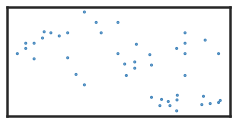

In [253]:
df = pd.DataFrame(xy, columns = ['x', 'y'])
y2 = [0 for i in range(len(xy))] 
vis_2d_(xy,y2)
xy.shape

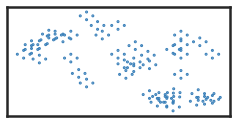

In [15]:
points_discs = anchors_to_contour(np.array(xy))
points_discs.shape
y3 = [0 for i in range(len(points_discs))] 
vis_2d_(points_discs,y3)

In [16]:
concave_hulls = get_concave_hull(points_discs, alpha=0.4, spline=False, vis=True, douglas_peucker_tolerance=0, smooth_iter=5)
concave_hulls

[array([[ 4.79375   , 10.19375   ],
        [ 4.80625   , 10.20625   ],
        [ 4.81875   , 10.21796875],
        ...,
        [ 4.7640625 , 10.16552734],
        [ 4.7796875 , 10.18017578],
        [ 4.79375   , 10.19375   ]])]

In [17]:
birch = Birch(threshold=2, branching_factor=2, n_clusters=None)

df['sub-cluster'] = birch.fit_predict(df.values)
# birch.subcluster_centers_

In [18]:
df_centroids = pd.DataFrame(birch.subcluster_centers_, columns=['x', 'y'])
df

,x,y,sub-cluster
0,1.00,6.00,0
1,1.50,6.50,0
2,1.50,7.00,0
3,2.00,5.50,0
4,2.00,7.00,0
5,2.50,7.50,0
6,2.60,8.10,0
7,3.00,8.00,0
8,3.50,7.70,0
9,4.00,8.00,0


In [19]:
anchor_labels = df_centroids.index.tolist()
anchor_labels
low_dim_anchors = df_centroids.values
df
points_perSubCluster = df.groupby("sub-cluster").size().tolist()

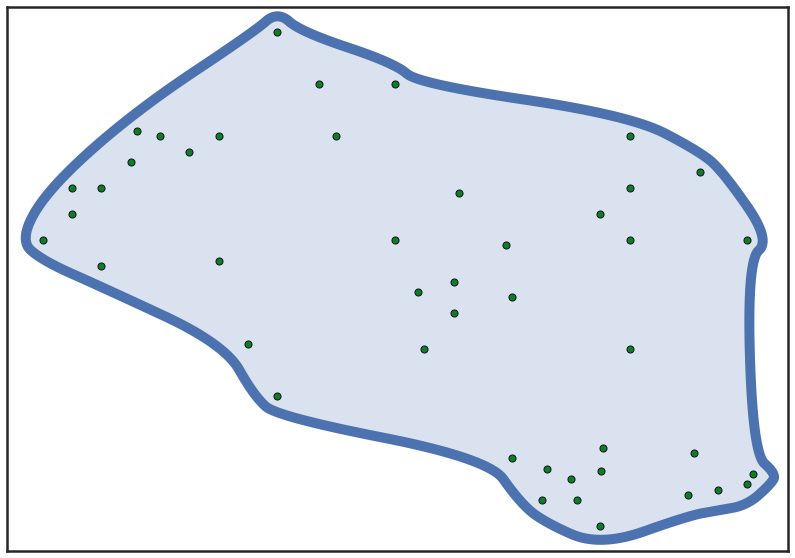

In [20]:
points_anchors_patches_plot(df, df_centroids, concave_hulls,
                            show_inner_blobs=False, show_points=True, show_anchors=False, show_polygons=True)

1

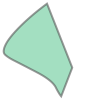

(0.71103515625, 2.8879703808783663, 5.492501023258711, 9.349018402738338)

1

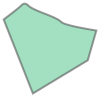

(3.7317209363862647, 4.886520914911976, 9.319276968433204, 10.3)

1

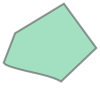

(4.7212620058676755, 1.6098086952594741, 11.00037255637448, 6.887377806614371)

1

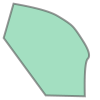

(8.803996731618875, 3.8369616326036984, 13.266796875, 8.679841130401055)

1

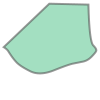

(8.612492391930214, 0.23623046874999998, 13.460058593749997, 3.884549267862203)

Text(0.5, 0, '')

Text(0, 0.5, '')

[0.7925441334884317,
 0.358565121256275,
 0.36656457590210384,
 0.48435709590719195,
 1.0863811510650896]

0

0.596275699432116

1

0.0

2

0.010991039381105934

3

0.17283485042773855

4

1.0

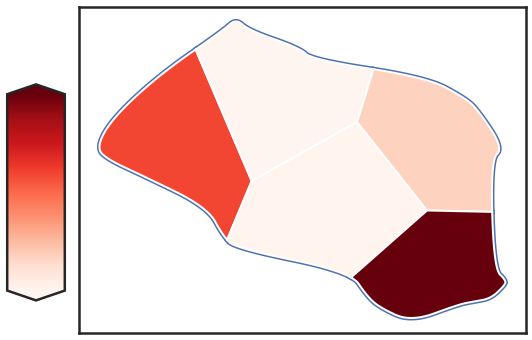

In [23]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 
import matplotlib.cm as cm
import matplotlib as mpt

show_inner_blobs=True
show_points=True
show_anchors=True
show_polygons=True
fig, ax = plt.subplots(figsize=(8, 6))

# Plot points
if show_points:
    sns.scatterplot(data=df, x='x', y='y',
                    ax=ax, color='green', s=50, linewidth=1, edgecolor='black')
# Plot anchors
if show_anchors:
    sns.scatterplot(data=df_centroids, x='x', y='y',
                    ax=ax, color='red', s=250, linewidth=1, edgecolor='black')

# Add patches
pathAll = []
areaInfo = {}
if show_polygons:
    palette = itertools.cycle(sns.color_palette())
    c = next(palette)
    for concave_hull in concave_hulls:
        # Skip polygons with very small area that will appear as dots
#         Polygon(concave_hull).area 
#         if Polygon(concave_hull).area < 0.001:
#             self.print_verbose(f'Skipping polygon of label {label} with area {Polygon(concave_hull).area}')
#             continue
        coords = concave_hull
        line_cmde = [Path.MOVETO] + [Path.LINETO] * (len(coords) - 2) + [Path.CLOSEPOLY]
        path = Path(coords, line_cmde)
        patch = patches.PathPatch(path, facecolor=c, alpha=0.2, linewidth=None, edgecolor=None)
#         ax.add_patch(patch)
        patch = patches.PathPatch(path, facecolor=None, linewidth=10, edgecolor=c, fill=False)
#         ax.add_patch(patch)
    if show_inner_blobs:
        points = df_centroids[['x', 'y']].values
        vor = Voronoi(points)

        regions, vertices = voronoi_finite_polygons_2d(vor)
        
#         concave_hulls
#         concave_hulls[0]
        mask = Polygon(concave_hulls[0])
#         mask
        for region in regions:
            polygon = vertices[region]
            shape = list(polygon.shape)
            shape[0] += 1 
            p = Polygon(np.append(polygon, polygon[0]).reshape(*shape)).intersection(mask)#创建轮廓
            tmpLabel = -1
            for anchor, anchor_label in zip(df_centroids.values, anchor_labels):
                anchor_p = Point(anchor)
                if p.contains(anchor_p):
                    areaInfo[anchor_label] = p.area
                    tmpLabel = anchor_label
            tmpDensity = points_perSubCluster[tmpLabel]/p.area
            # intersection can create MultiPolygon
            if isinstance(p, shapely.geometry.polygon.Polygon):
                polygons = [p]

#                 polygons = []
            else:  # Multipolygon
#                 polygons = list(p)
                polygons = list(p)

            len(polygons)
            polygons[0]
            polygons[0].bounds
            for p in list(polygons):
                # skip anchors outside the polygon due to simplification
                if p.exterior is None:
                    continue
                x, y = p.exterior.coords.xy
                inner_blob = list(zip(x,y))
#                 inner_blob = list(zip(1,2))
                #plot patch
                line_cmde = [Path.MOVETO] + [Path.LINETO] * (len(inner_blob) - 2) + [Path.CLOSEPOLY]
                path = Path(inner_blob, line_cmde)
                patch = patches.PathPatch(path, facecolor=None, linewidth=5, edgecolor=c, fill=None)
                ax.add_patch(patch)
                pathAll.append(path)
#                 patch = patches.PathPatch(path, facecolor=cm.Reds(tmpDensity), alpha=0.2, linewidth=None, edgecolor=None)
#                 ax.add_patch(patch)

# remove ticks
ax.xaxis.set_major_locator(plt.NullLocator())
ax.yaxis.set_major_locator(plt.NullLocator())
# remove labels
ax.set_xlabel("")
ax.set_ylabel("")


densityInfo = {}
for i in areaInfo:
    tmpArea = areaInfo[i]
    densityInfo[i] = points_perSubCluster[i] / tmpArea
density_list = list(densityInfo.values())
density_list



cmap =cm.Reds
ax3 = fig.add_axes([0, 0.2, 0.1, 0.5]) # 四个参数分别是左、下、宽、长
colorMin = min(density_list)
colorMax = max(density_list)

norm = mpt.colors.Normalize(vmin=colorMin, vmax=colorMax)

# norm(colorMax)
bounds = [ round(elem, 2) for elem in np.linspace(1.3, 2.5, 14)] # 
cb3 = mpt.colorbar.ColorbarBase(ax3, cmap=cmap,norm=norm,extend='both',ticks=bounds,spacing='proportional',orientation='vertical')

for index,path in enumerate(pathAll):
    index
    norm(density_list[index])
    patch = patches.PathPatch(path, facecolor=cm.Reds(norm(density_list[index])), alpha=1, linewidth=None, edgecolor=None)
    ax.add_patch(patch)
# colorMin
# norm(0.7925441334884317)
# density_list
plt.show()

# Transpose the point

(180, 2)

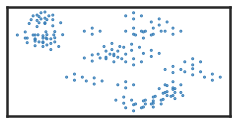

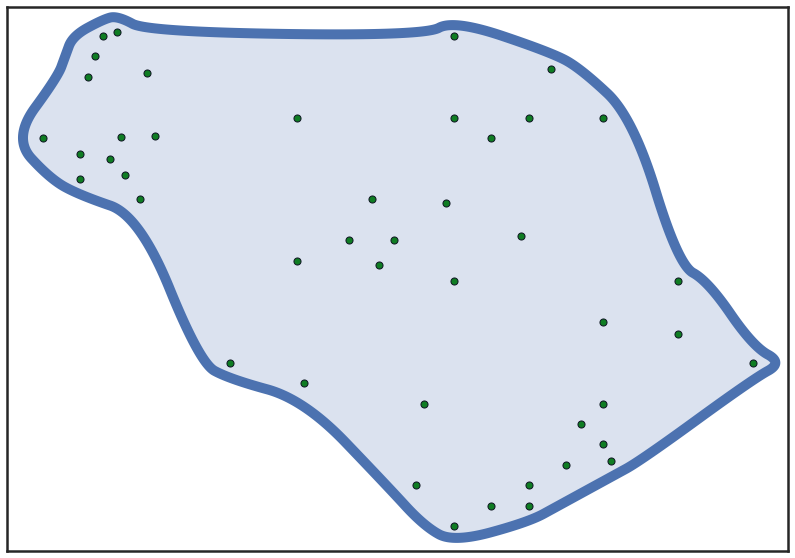

In [399]:
low_dim_points = xy
# points_discs = anchors_to_contour(np.array(xy))

rotate_low_dim_points = low_dim_points.copy()
rotate_low_dim_anchors = low_dim_anchors.copy()
rotate_low_dim_points[:, [0, 1]] = rotate_low_dim_points[:, [1, 0]]
rotate_low_dim_anchors[:, [0, 1]] = rotate_low_dim_anchors[:, [1, 0]]
rotate_low_dim_points_dics = anchors_to_contour(np.array(rotate_low_dim_points))
rotate_low_dim_points_dics.shape
vis_2d_(rotate_low_dim_points_dics,y3)
# df
# df_centroids
# rotate_low_dim_anchors


rotate_concave_hulls = get_concave_hull(rotate_low_dim_points_dics, alpha=0.4, spline=False, vis=True, douglas_peucker_tolerance=0, smooth_iter=5)
rotate_df = df.copy()
rotate_df[["x","y"]] = rotate_low_dim_points
rotate_df_centroids = df_centroids.copy()
rotate_df_centroids[["x","y"]] = rotate_low_dim_anchors
points_anchors_patches_plot(rotate_df, rotate_df_centroids, rotate_concave_hulls,
                            show_inner_blobs=False, show_points=True, show_anchors=False, show_polygons=True)

# Offset the point

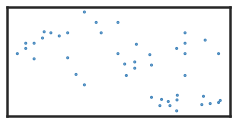

In [385]:
offset = 0.5
low_dim_points = xy
trans_low_dim_points = low_dim_points.copy()
trans_low_dim_anchors = low_dim_anchors.copy()
trans_low_dim_points = trans_low_dim_points + offset
trans_low_dim_anchors = trans_low_dim_anchors + offset
vis_2d_(trans_low_dim_points,y2)
# df
# df_centroids
# trans_low_dim_anchors

trans_concave_hulls = get_concave_hull(trans_low_dim_points, alpha=0.4, spline=False, vis=True, douglas_peucker_tolerance=0, smooth_iter=5)
trans_df = df.copy()
trans_df[["x","y"]] = trans_low_dim_points
trans_df_centroids = df_centroids.copy()
trans_df_centroids[["x","y"]] = trans_low_dim_anchors
# points_anchors_patches_plot(trans_df, trans_df_centroids, trans_concave_hulls,
#                             show_inner_blobs=True, show_points=True, show_anchors=True, show_polygons=True)

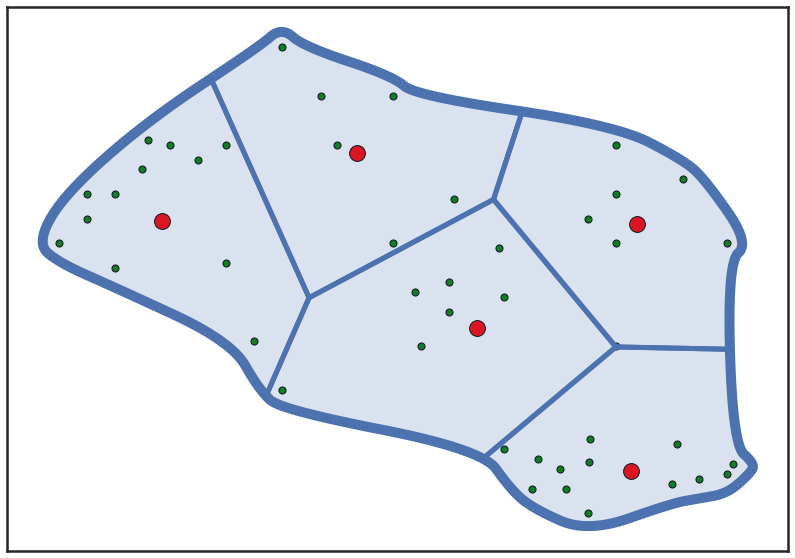

In [386]:
points_anchors_patches_plot(df, df_centroids, concave_hulls,
                            show_inner_blobs=True, show_points=True, show_anchors=True, show_polygons=True)

In [24]:
areaInfo
points_perSubCluster

{0: 15.141112643382096,
 1: 16.733362070962997,
 2: 19.096226040863936,
 3: 14.45214710210682,
 4: 11.966334271590393}

[12, 6, 7, 7, 13]

# Generate Virtual Points

1. Map the num of poinst to radius
2. Normal generate the points in a ball around the anchor
3. 

(2.853846153846154, 6.453846153846155)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

(6.35, 7.833333333333333)

[1, 1, 1, 1, 1, 1]

(8.5, 4.275)

[2, 2, 2, 2, 2, 2, 2]

(11.385714285714286, 6.385714285714284)

[3, 3, 3, 3, 3, 3, 3]

(11.269090909090908, 1.3681818181818184)

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]

[]

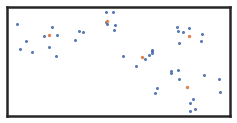

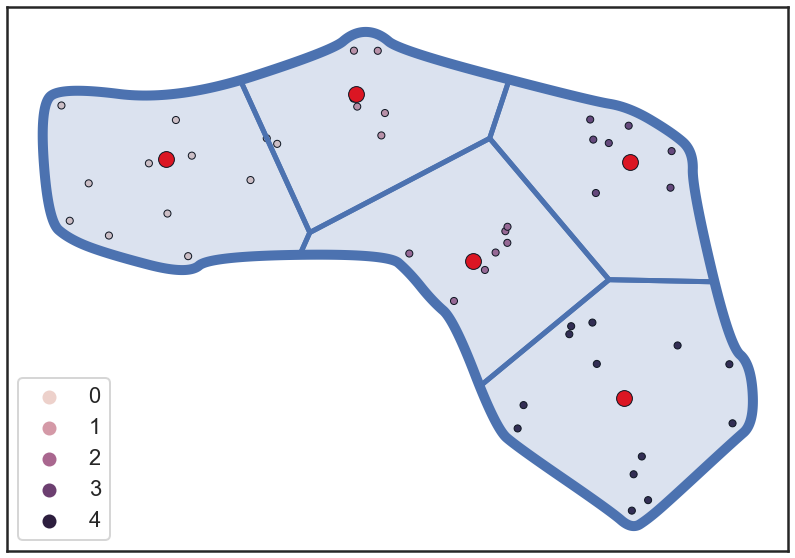

In [316]:
# from sklearn.preprocessing import MinMaxScaler

scaleRange = (1,2.5)
range_points = np.array(points_perSubCluster)
domain_points = np.interp(range_points, (range_points.min(), range_points.max()), scaleRange)

def random_ball(num_points,radius,dimension=2,offset=(1,0)):
    from numpy import random, linalg
    # First generate random directions by normalizing the length of a
    # vector of random-normal values (these distribute evenly on ball).
    random_directions = random.normal(size=(dimension,num_points))
    random_directions /= linalg.norm(random_directions, axis=0)
    # Second generate a random radius with probability proportional to
    # the surface area of a ball with a given radius.
    random_radii = random.random(num_points) ** (1/dimension)
    # Return the list of random (direction & length) points.
    return radius * (random_directions * random_radii).T + offset


# domain_points

virtual_points = []
virtual_points_y = []
for index,item in enumerate(domain_points):
    tmp_num = range_points[index]
    tmp_radius = domain_points[index]
    offset = (low_dim_anchors[index][0],low_dim_anchors[index][1])
    offset
    tmpData = random_ball(tmp_num,tmp_radius,2,offset)
    tmpY = np.full(tmp_num,index).tolist()
    tmpY
    virtual_points_y.extend(tmpY)
    virtual_points.append(tmpData)
#     sns.set(style='white', context='poster')
#     fig, ax = plt.subplots(1, figsize=(4, 2))
#     plt.scatter(*tmpData.T, s=1, cmap='Spectral', alpha=1.0)
#     plt.setp(ax, xticks=[], yticks=[])
# def gen_ball(radius,num):
#     for i in range(num):
#         theta = random.uniform(0, 2 * np.pi)
#         r = math.sqrt(random.uniform(0, radius ** 2))
#         a.append(r * math.cos(theta))
#         b.append(r * math.sin(theta))
#     return a,b
all_virtual_points = np.vstack(virtual_points)
fig, ax = plt.subplots(1, figsize=(4, 2))
ax.scatter(*all_virtual_points.T, s=1, cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
ax.scatter(*low_dim_anchors.T, s=2, cmap='Spectral', alpha=1.0)
all_virtual_points_dics = anchors_to_contour(np.array(all_virtual_points))
virtual_points_concave_hulls = get_concave_hull(all_virtual_points_dics, alpha=0.4, spline=False, vis=True, douglas_peucker_tolerance=0, smooth_iter=5)
df_virtual_points = pd.DataFrame(all_virtual_points,columns=['x','y'])
df_virtual_points['sub-cluster'] = virtual_points_y
points_anchors_patches_plot_colors(df_virtual_points, df_centroids, virtual_points_concave_hulls,
                            show_inner_blobs=True, show_points=True, show_anchors=True, show_polygons=True)

[]

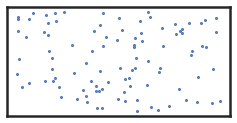

In [434]:
x1 = np.random.uniform(0, 1,100)
x2 = np.random.uniform(0, 1,100)
xy4 = list(zip(x1,x2))
xy5 = [list(i) for i in xy4]
xy5 = np.array(xy5)
# y = np.zeros(1000).tolist()
sns.set(style='white', context='poster')
fig, ax = plt.subplots(1, figsize=(4, 2))
plt.scatter(*xy5.T, s=1, cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])


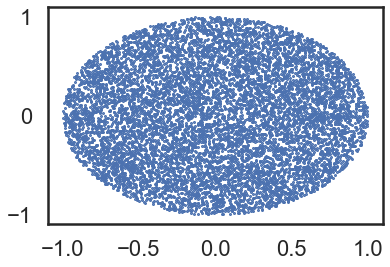

In [441]:
import random
import math
a = []
b = []

plt.scatter(a,b, s=1, cmap='Spectral', alpha=1.0)


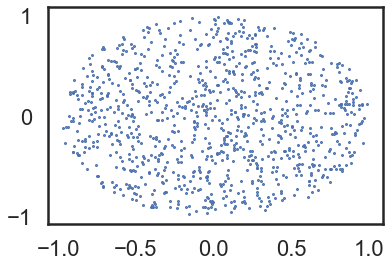

In [443]:
a = []
b = []
for i in range(1000):
    theta = random.uniform(0, 2 * np.pi)
    r = math.sqrt(random.uniform(0, 1 ** 2))
    a.append(r * math.cos(theta))
    b.append(r * math.sin(theta))
plt.scatter(a,b, s=1, cmap='Spectral', alpha=1.0)